In [1]:
from dna_features_viewer import GraphicFeature, GraphicRecord, BiopythonTranslator
import pandas as pd
import os
from Bio import SeqIO, Entrez
import numpy as np
import pprint
from BCBio import GFF


In [39]:
os.chdir('/Users/callamartyn/chou_lab/alongshan/paper_repo/')
rdrp_sum=pd.read_csv('./rdrp_sum.csv')

In [2]:
features=[
    GraphicFeature(start=0, end=20, strand=+1, color="#ffd700",
                   label="Small feature"),
    GraphicFeature(start=20, end=500, strand=+1, color="#ffcccc",
                   label="Gene 1 with a very long name"),
    GraphicFeature(start=400, end=700, strand=-1, color="#cffccc",
                   label="Gene 2"),
    GraphicFeature(start=600, end=900, strand=+1, color="#ccccff",
                   label="Gene 3")
]

(<AxesSubplot:>,
 ({GF(Small feature, 0-20 (1)): 0,
   GF(Gene 1 with a very long name, 20-500 (1)): 0,
   GF(Gene 2, 400-700 (-1)): 1.0,
   GF(Gene 3, 600-900 (1)): 0},
  {GF(Gene 1 with a very long name, 20-500 (1)): {'feature_y': 0,
    'annotation_y': 2.0},
   GF(Small feature, 0-20 (1)): {'feature_y': 0, 'annotation_y': 1.0}}))

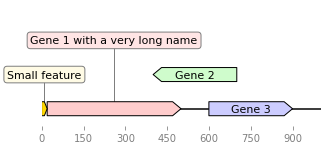

In [3]:
record = GraphicRecord(sequence_length=1000, features=features)
record.plot(figure_width=5)

In [104]:
# in_file = "../out/assemblies/t1_t2.gff3"
# fasta_input = SeqIO.to_dict(SeqIO.parse('./virus_rep_seqs.fasta', "fasta"))
# gff_iter = GFF.parse("../out/assemblies/t1_t2.gff3", fasta_input)
# SeqIO.write(gff_iter, 'virus_rep_seqs.gbk', "genbank")
targets=list(rdrp_sum[rdrp_sum.type=='virus'].contig_id)
for r in SeqIO.parse('./t1_t2.gbk', 'genbank'):
    print(r)


In [103]:
annotations

[]

In [72]:
header=header=['contig_id', 'qlen', 'qframe', 'qstart', 'qend', 'sseqid', 'slen', 'evalue', 'bitscore', 'a_length',
        'pident', 'nident', 'gaps', 'staxids', 'sname']
cc_blast=pd.read_csv('./cooccurring_contigs.tsv',sep='\t', names=header)
cc_blast['org']=[s[s.find("[")+1:s.find("]")] for s in cc_blast.sname]

In [27]:
orgToTaxid={}
taxidToLineage={}
for i, row in cc_blast.iterrows():
    if row.staxids is np.nan: # if taxid is missing, search for it using the organism name
        n=row.org
        if n in orgToTaxid: 
            continue # skip if already seen
        else:
            Entrez.email = 'calla.martyn@ucsf.edu'
            handle = Entrez.esearch(db='taxonomy', term=n, retmode="xml") # search tax database using organism name
            taxid = Entrez.read(handle)['IdList'][0] # get taxid from results handle
            orgToTaxid[n]=taxid # add organism to taxid mapping to dictionary
            handle.close()
    else:
        taxid=row.staxids # else grab the provided taxid
    if taxid in taxidToLineage: 
        continue # skip if already seen
    else:
        Entrez.email = 'calla.martyn@ucsf.edu'
        handle = Entrez.efetch(db='taxonomy', id=str(taxid), retmode="xml") # search taxonomy database using taxid
        record = Entrez.read(handle)
        id_dict = {}
        for x in record[0]['LineageEx']:
            id_dict[x['Rank']] = x['ScientificName'] # dictionary of {'kingdom': 'Viruses', 'family' : 'Rhabdoviridae'}, etc
        handle.close()
        taxidToLineage[taxid] = id_dict # dictionary of {'12345': {'family' 'Rhabdoviridae',...}} etc
                
        

In [73]:
cc_blast.staxids.fillna(cc_blast.org.map(orgToTaxid), inplace=True)

In [74]:
# map  the taxid to to each rank of interest (can also add class, subspecies, etc)
cc_blast.staxids.fillna(cc_blast.org.map(orgToTaxid), inplace=True)
cc_blast['superkingdom']= [taxidToLineage[x].get('superkingdom') for x in cc_blast['staxids']]
cc_blast['clade'] = [taxidToLineage[x].get('clade') for x in cc_blast['staxids']]
cc_blast['kingdom']= [taxidToLineage[x].get('kingdom') for x in cc_blast['staxids']]
cc_blast['order'] = [taxidToLineage[x].get('order') for x in cc_blast['staxids']]
cc_blast['family'] = [taxidToLineage[x].get('family') for x in cc_blast['staxids']]
cc_blast['genus'] = [taxidToLineage[x].get('genus') for x in cc_blast['staxids']]
cc_blast['species'] = [taxidToLineage[x].get('species') for x in cc_blast['staxids']]
cc_blast['no_rank'] = [taxidToLineage[x].get('no rank') for x in cc_blast['staxids']]

# fill in empty ranks with next rank up
cc_blast['species']=cc_blast['species'].fillna(cc_blast['org']) 
cc_blast['genus']=cc_blast['genus'].fillna(cc_blast['no_rank'])
cc_blast['family']=cc_blast['family'].fillna(cc_blast['no_rank'])
cc_blast['order']=cc_blast['order'].fillna(cc_blast['no_rank'])
cc_blast['clade']=cc_blast['clade'].fillna(cc_blast['no_rank'])
cc_blast['kingdom']= cc_blast['kingdom'].fillna(cc_blast['no_rank'])
cc_blast['no_rank']=cc_blast['no_rank'].fillna(cc_blast['species'])
cc_blast['superkingdom']= cc_blast['superkingdom'].fillna(cc_blast['no_rank'])

In [75]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
cc_blast.to_csv('./cooccurring_contigs_blast.tsv', index=False)
cc_blast

,contig_id,qlen,qframe,qstart,qend,sseqid,slen,evalue,bitscore,a_length,pident,nident,gaps,staxids,sname,org,superkingdom,clade,kingdom,order,family,genus,species,no_rank
0,t1_NODE_6_length_4237_cov_112.080105,4237,-3,4184,204,BBD75426.1,1350,0.000000e+00,1663.7,1351,58.3,788,26,1752929,BBD75426.1 glycoprotein precursor [Ixodes scap...,Ixodes scapularis bunyavirus,Viruses,Riboviria,Orthornavirae,Bunyavirales,Peribunyaviridae,unclassified Peribunyaviridae,Ixodes scapularis bunyavirus,unclassified Peribunyaviridae
1,t1_NODE_6_length_4237_cov_112.080105,4237,-3,4184,204,ASY03251.1,1350,0.000000e+00,1645.9,1350,57.6,777,24,2034337,ASY03251.1 glycoprotein [Bronnoya virus],Bronnoya virus,Viruses,Riboviria,Orthornavirae,Bunyavirales,unclassified Bunyavirales,unclassified Bunyavirales,Bronnoya virus,unclassified Bunyavirales
2,t1_NODE_6_length_4237_cov_112.080105,4237,-3,3062,393,QPD01627.1,1399,5.200000e-185,659.4,904,36.9,334,30,2789421,QPD01627.1 glycoprotein precursor [Volzhskoe t...,Volzhskoe tick virus,Viruses,Riboviria,Orthornavirae,Bunyavirales,unclassified Bunyavirales,unclassified Bunyavirales,Volzhskoe tick virus,unclassified Bunyavirales
3,t1_NODE_6_length_4237_cov_112.080105,4237,-3,1637,465,QNS31052.1,1447,7.000000e-57,233.8,395,31.6,125,14,2792510,QNS31052.1 putative RNA dependent RNA polymera...,Thrips tabaci associated bunyavirales 4,Viruses,Riboviria,Orthornavirae,Bunyavirales,unclassified Bunyavirales,unclassified Bunyavirales,Thrips tabaci associated bunyavirales 4,unclassified Bunyavirales
4,t1_NODE_6_length_4237_cov_112.080105,4237,-3,1514,336,YP_009553308.1,802,5.600000e-38,171.0,399,26.1,104,18,2315724,YP_009553308.1 glycoprotein N [Athtab bunya-li...,Athtab bunya-like virus,Viruses,Riboviria,Orthornavirae,Bunyavirales,unclassified Bunyavirales,unclassified Bunyavirales,Athtab bunya-like virus,unclassified Bunyavirales
5,t1_NODE_6_length_4237_cov_112.080105,4237,-3,1730,273,AJG39290.2,793,4.700000e-37,167.9,494,25.9,128,38,1608096,AJG39290.2 glycoprotein precursor [Whenzhou Sh...,Whenzhou Shrimp Virus 2,Viruses,Riboviria,unclassified ssRNA negative-strand viruses,unclassified ssRNA negative-strand viruses,unclassified ssRNA negative-strand viruses,unclassified ssRNA negative-strand viruses,Whenzhou Shrimp Virus 2,unclassified ssRNA negative-strand viruses
6,t1_NODE_6_length_4237_cov_112.080105,4237,-3,1733,573,ASM94074.1,380,6.900000e-28,137.5,394,25.1,99,26,2021934,"ASM94074.1 putative glycoprotein, partial [Lot...",Lothians earthworm bunya/orthobunya-like virus 1,Viruses,Riboviria,Orthornavirae,Bunyavirales,unclassified Bunyavirales,unclassified Bunyavirales,Lothians earthworm bunya/orthobunya-like virus 1,unclassified Bunyavirales
7,t1_NODE_6_length_4237_cov_112.080105,4237,-3,1604,231,YP_009666937.1,1446,1.600000e-21,116.3,490,25.5,125,66,1623310,YP_009666937.1 polyprotein [Tataguine virus],Tataguine virus,Viruses,Riboviria,Orthornavirae,Bunyavirales,Peribunyaviridae,Orthobunyavirus,Tataguine orthobunyavirus,Tataguine orthobunyavirus
8,t1_NODE_6_length_4237_cov_112.080105,4237,-3,1604,231,AXS76880.1,1446,2.800000e-21,115.5,490,25.3,124,66,1623310,AXS76880.1 polyprotein [Tataguine virus],Tataguine virus,Viruses,Riboviria,Orthornavirae,Bunyavirales,Peribunyaviridae,Orthobunyavirus,Tataguine orthobunyavirus,Tataguine orthobunyavirus
9,t1_NODE_6_length_4237_cov_112.080105,4237,-3,1604,231,QLA46885.1,1446,2.800000e-21,115.5,490,25.3,124,66,1623310,QLA46885.1 polyprotein [Tataguine virus],Tataguine virus,Viruses,Riboviria,Orthornavirae,Bunyavirales,Peribunyaviridae,Orthobunyavirus,Tataguine orthobunyavirus,Tataguine orthobunyavirus


In [139]:
header=header=['orf_id', 'qlen', 'qframe', 'qstart', 'qend', 'sseqid', 'slen', 'evalue', 'bitscore', 'a_length',
        'pident', 'nident', 'gaps', 'staxids', 'sname']
rdrp_blast=pd.read_csv('./virus_rep_proteins_blast.tsv',sep='\t', names=header)
rdrp_blast['org']=[s[s.find("[")+1:s.find("]")] for s in rdrp_blast.sname]

In [107]:
for i, row in rdrp_blast.iterrows():
    if row.staxids is np.nan: # if taxid is missing, search for it using the organism name
        n=row.org
        if n in orgToTaxid: 
            continue # skip if already seen
        else:
            Entrez.email = 'calla.martyn@ucsf.edu'
            handle = Entrez.esearch(db='taxonomy', term=n, retmode="xml") # search tax database using organism name
            taxid = Entrez.read(handle)['IdList'][0] # get taxid from results handle
            orgToTaxid[n]=taxid # add organism to taxid mapping to dictionary
            handle.close()
    else:
        taxid=row.staxids # else grab the provided taxid
    if taxid in taxidToLineage: 
        continue # skip if already seen
    else:
        Entrez.email = 'calla.martyn@ucsf.edu'
        handle = Entrez.efetch(db='taxonomy', id=str(taxid), retmode="xml") # search taxonomy database using taxid
        record = Entrez.read(handle)
        id_dict = {}
        for x in record[0]['LineageEx']:
            id_dict[x['Rank']] = x['ScientificName'] # dictionary of {'kingdom': 'Viruses', 'family' : 'Rhabdoviridae'}, etc
        handle.close()
        taxidToLineage[taxid] = id_dict # dictionary of {'12345': {'family' 'Rhabdoviridae',...}} etc
                
        

In [140]:
# map  the taxid to to each rank of interest (can also add class, subspecies, etc)
rdrp_blast.staxids.fillna(rdrp_blast.org.map(orgToTaxid), inplace=True)
rdrp_blast['superkingdom']= [taxidToLineage[x].get('superkingdom') for x in rdrp_blast['staxids']]
rdrp_blast['clade'] = [taxidToLineage[x].get('clade') for x in rdrp_blast['staxids']]
rdrp_blast['kingdom']= [taxidToLineage[x].get('kingdom') for x in rdrp_blast['staxids']]
rdrp_blast['order'] = [taxidToLineage[x].get('order') for x in rdrp_blast['staxids']]
rdrp_blast['family'] = [taxidToLineage[x].get('family') for x in rdrp_blast['staxids']]
rdrp_blast['genus'] = [taxidToLineage[x].get('genus') for x in rdrp_blast['staxids']]
rdrp_blast['species'] = [taxidToLineage[x].get('species') for x in rdrp_blast['staxids']]
rdrp_blast['no_rank'] = [taxidToLineage[x].get('no rank') for x in rdrp_blast['staxids']]

# fill in empty ranks with next rank up
rdrp_blast['species']=rdrp_blast['species'].fillna(rdrp_blast['org']) 
rdrp_blast['genus']=rdrp_blast['genus'].fillna(rdrp_blast['no_rank'])
rdrp_blast['family']=rdrp_blast['family'].fillna(rdrp_blast['no_rank'])
rdrp_blast['order']=rdrp_blast['order'].fillna(rdrp_blast['no_rank'])
rdrp_blast['clade']=rdrp_blast['clade'].fillna(rdrp_blast['no_rank'])
rdrp_blast['kingdom']= rdrp_blast['kingdom'].fillna(rdrp_blast['no_rank'])
rdrp_blast['no_rank']=rdrp_blast['no_rank'].fillna(rdrp_blast['species'])
rdrp_blast['superkingdom']= rdrp_blast['superkingdom'].fillna(rdrp_blast['no_rank'])

In [141]:
rdrp_blast.to_csv('./virus_rep_proteins_blast.csv', index=False)
# rdrp_blast.sort_values(by='bitscore', ascending=False,inplace=True)
# rdrp_blast.drop_duplicates(subset=['orf_id'], keep='first',inplace=True)

In [132]:
rdrp_blast.insert( 0, 'virus_name', rdrp_blast.orf_id.str.replace('t[1-2]_' ,'').map(
    dict(zip(rdrp_sum.orf_id, rdrp_sum.virus_name))))

<ipython-input-132-caf4ba131362>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  rdrp_blast.insert( 0, 'virus_name', rdrp_blast.orf_id.str.replace('t[1-2]_' ,'').map(


In [134]:
rdrp_blast.to_csv('./virus_rep_proteins_blast_trunc.tsv', index=False)

In [37]:
rdrp_blast=pd.read_csv('./virus_rep_proteins_blast.tsv')

VLTs

In [32]:
targets=list(rdrp_sum[rdrp_sum.type=='vlt'].contig_id)
input_seq_iterator=SeqIO.parse('./all_contigs_prot.fasta', 'fasta')
queries=[r for r in input_seq_iterator if re.sub('_\d$', '',r.id) in targets]

In [34]:
SeqIO.write(queries, './vlt_proteins.fasta', 'fasta')

78

In [41]:
header=header=['orf_id', 'qlen', 'qframe', 'qstart', 'qend', 'sseqid', 'slen', 'evalue', 'bitscore', 'a_length',
        'pident', 'nident', 'gaps', 'staxids', 'sname']
vlt_blast=pd.read_csv('./vlt_blast.tsv',sep='\t', names=header)
vlt_blast['org']=[s[s.find("[")+1:s.find("]")] for s in vlt_blast.sname]
orgToTaxid={}
taxidToLineage={}
for i, row in vlt_blast.iterrows():
    if row.staxids is np.nan: # if taxid is missing, search for it using the organism name
        n=row.org
        if n in orgToTaxid: 
            continue # skip if already seen
        else:
            Entrez.email = 'calla.martyn@ucsf.edu'
            handle = Entrez.esearch(db='taxonomy', term=n, retmode="xml") # search tax database using organism name
            taxid = Entrez.read(handle)['IdList'][0] # get taxid from results handle
            orgToTaxid[n]=taxid # add organism to taxid mapping to dictionary
            handle.close()
    else:
        taxid=row.staxids # else grab the provided taxid
    if taxid in taxidToLineage: 
        continue # skip if already seen
    else:
        Entrez.email = 'calla.martyn@ucsf.edu'
        handle = Entrez.efetch(db='taxonomy', id=str(taxid), retmode="xml") # search taxonomy database using taxid
        record = Entrez.read(handle)
        id_dict = {}
        for x in record[0]['LineageEx']:
            id_dict[x['Rank']] = x['ScientificName'] # dictionary of {'kingdom': 'Viruses', 'family' : 'Rhabdoviridae'}, etc
        handle.close()
        taxidToLineage[taxid] = id_dict # dictionary of {'12345': {'family' 'Rhabdoviridae',...}} etc
                
# map  the taxid to to each rank of interest (can also add class, subspecies, etc)
vlt_blast.staxids.fillna(vlt_blast.org.map(orgToTaxid), inplace=True)
vlt_blast['superkingdom']= [taxidToLineage[x].get('superkingdom') for x in vlt_blast['staxids']]
vlt_blast['clade'] = [taxidToLineage[x].get('clade') for x in vlt_blast['staxids']]
vlt_blast['kingdom']= [taxidToLineage[x].get('kingdom') for x in vlt_blast['staxids']]
vlt_blast['order'] = [taxidToLineage[x].get('order') for x in vlt_blast['staxids']]
vlt_blast['family'] = [taxidToLineage[x].get('family') for x in vlt_blast['staxids']]
vlt_blast['genus'] = [taxidToLineage[x].get('genus') for x in vlt_blast['staxids']]
vlt_blast['species'] = [taxidToLineage[x].get('species') for x in vlt_blast['staxids']]
vlt_blast['no_rank'] = [taxidToLineage[x].get('no rank') for x in vlt_blast['staxids']]

# fill in empty ranks with next rank up
vlt_blast['species']=vlt_blast['species'].fillna(vlt_blast['org']) 
vlt_blast['genus']=vlt_blast['genus'].fillna(vlt_blast['no_rank'])
vlt_blast['family']=vlt_blast['family'].fillna(vlt_blast['no_rank'])
vlt_blast['order']=vlt_blast['order'].fillna(vlt_blast['no_rank'])
vlt_blast['clade']=vlt_blast['clade'].fillna(vlt_blast['no_rank'])
vlt_blast['kingdom']= vlt_blast['kingdom'].fillna(vlt_blast['no_rank'])
vlt_blast['no_rank']=vlt_blast['no_rank'].fillna(vlt_blast['species'])
vlt_blast['superkingdom']= vlt_blast['superkingdom'].fillna(vlt_blast['no_rank'])  

vlt_blast.to_csv('./vlt_rep_proteins_blast.csv', index=False)
# vlt_blast.sort_values(by='bitscore', ascending=False,inplace=True)
# vlt_blast.drop_duplicates(subset=['orf_id'], keep='first',inplace=True)

In [51]:
vlt_blast.sort_values(by='bitscore', ascending=False,inplace=True)
vlt_blast.drop_duplicates(subset=['orf_id'], keep='first',inplace=True)
vlt_blast.drop(columns='cluster_85',inplace=True)
vlt_blast.insert(0, 'cluster_85', vlt_blast.orf_id.str.replace('_[0-9]$' ,'').map(
    dict(zip(rdrp_sum.contig_id, rdrp_sum.cluster_85))))

<ipython-input-51-f08919f5ad7a>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  vlt_blast.insert(0, 'cluster_85', vlt_blast.orf_id.str.replace('_[0-9]$' ,'').map(


In [54]:
pd.set_option('display.max_rows', 100)
vlt_blast.to_csv('./vlt_rep_proteins_blast.csv', index=False)